# GDP Predictor - Increasing/Decreasing
This is a classification model that uses transportation data to predict if GDP is increasing or decreasing.

## Setup the Environment

In [145]:
#Import needed libraries
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

## Get and Prep the Data
I am using transportation data published by the U.S. Department of Transportation Bureau of Transportation Statistics and GDP data from the St. Louis Federal Reserve Bank, which is compiled by the U.S. Department of Commerce Bureau of Economic Analysis. This step produces a data set that has transporation inputs and GDP data.

In [2]:
#Read in the transportation data, monthly seasonally adjusted
tsi_data = pd.read_excel(".\data\Input_SeasonalData_TSI.xlsx", header=2)

#look at the data types that were inferred by Pandas during import.
tsi_data.dtypes

OBS_DATE                   datetime64[ns]
RAIL_FRT_CARLOADS_D11               int64
RAIL_FRT_INTERMODAL_D11             int64
WATERBORNE_D11                    float64
TRUCK_D11                         float64
AIR_RTMFM_D11                       int64
TSI                               float64
dtype: object

In [3]:
#Return a listing of the data
tsi_data.head()

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI
0,2000-01-01,1422442,764756,55.4,80.3,2466950,105.3
1,2000-02-01,1425882,767958,48.6,79.8,2521852,104.4
2,2000-03-01,1411458,763858,52.5,74.1,2489787,99.2
3,2000-04-01,1400311,764144,50.8,72.8,2557332,98.1
4,2000-05-01,1405169,763843,52.5,73.0,2527821,98.6


In [4]:
#Read in the real gdp growth rates,seasonally adjusted, quarterly data with quarterly growth rates
gdp_data = pd.read_excel(".\data\Input_GDP_st_louis_fed_quarterly_change.xlsx")

#look at the data types that were inferred by Pandas during import.
gdp_data.dtypes

observation_date       datetime64[ns]
Real_gdp_qtr_growth           float64
dtype: object

In [5]:
# Divide the gdp qtr growth rate by 100 as all rates of change will use a format of 10% = 0.10
gdp_data.Real_gdp_qtr_growth = gdp_data.Real_gdp_qtr_growth/100.0

In [6]:
#Disply a listing of the data
gdp_data.head()

,observation_date,Real_gdp_qtr_growth
0,2000-01-01,0.015
1,2000-04-01,0.075
2,2000-07-01,0.005
3,2000-10-01,0.025
4,2001-01-01,-0.011


In [7]:
# Merge the transportation and GDP data into a new dataset based on the date.
merged_data = pd.merge(tsi_data, gdp_data, how='left', left_on='OBS_DATE', right_on='observation_date')

#We now have 2 date columns with different names. Drop one of the date columns.
merged_data = merged_data.drop(['observation_date'], axis=1) #pandas can drop rows or columns, axis=1 indicates columns

merged_data.head()

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth
0,2000-01-01,1422442,764756,55.4,80.3,2466950,105.3,0.015
1,2000-02-01,1425882,767958,48.6,79.8,2521852,104.4,NaN
2,2000-03-01,1411458,763858,52.5,74.1,2489787,99.2,NaN
3,2000-04-01,1400311,764144,50.8,72.8,2557332,98.1,0.075
4,2000-05-01,1405169,763843,52.5,73.0,2527821,98.6,NaN


In [8]:
#Look at the counts for the data values that we have for each column.  We see the gdp data with a smaller number since
#it is quarterly and the other data is monthly.
merged_data.count()

OBS_DATE                   241
RAIL_FRT_CARLOADS_D11      241
RAIL_FRT_INTERMODAL_D11    241
WATERBORNE_D11             241
TRUCK_D11                  241
AIR_RTMFM_D11              241
TSI                        241
Real_gdp_qtr_growth         80
dtype: int64

In [9]:
#Forward fill the gdp data so that a quarterly gdp value will be used for 3 rows, with each row being a month.
#limit it only fill in 2 consective missing values.
merged_data['Real_gdp_qtr_growth'] = merged_data['Real_gdp_qtr_growth'].fillna(method='ffill', limit=2)

merged_data.head()

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth
0,2000-01-01,1422442,764756,55.4,80.3,2466950,105.3,0.015
1,2000-02-01,1425882,767958,48.6,79.8,2521852,104.4,0.015
2,2000-03-01,1411458,763858,52.5,74.1,2489787,99.2,0.015
3,2000-04-01,1400311,764144,50.8,72.8,2557332,98.1,0.075
4,2000-05-01,1405169,763843,52.5,73.0,2527821,98.6,0.075


In [10]:
#Look to see if we still have missing gdp values as that data gets released later than the transportation data.
#This will allow us to inspect any bad rows.
merged_data.loc[merged_data['Real_gdp_qtr_growth'].isnull()]

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth
240,2020-01-01,1054432,1109662,50.4,116.6,3617962,136.9,NaN


In [11]:
# Drop rows where we don't have a gdp value
merged_data = merged_data.dropna(subset=['Real_gdp_qtr_growth'])

# Verify that all rows have gdp values 
merged_data.loc[merged_data['Real_gdp_qtr_growth'].isnull()]

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth


In [12]:
#We should now have clean data.
merged_data.count()

OBS_DATE                   240
RAIL_FRT_CARLOADS_D11      240
RAIL_FRT_INTERMODAL_D11    240
WATERBORNE_D11             240
TRUCK_D11                  240
AIR_RTMFM_D11              240
TSI                        240
Real_gdp_qtr_growth        240
dtype: int64

In [13]:
# Create a boolean column to indicate if gdp growth was positive or negative.
#merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: True if x['Real_gdp_qtr_growth'] > 0.0 else False, axis=1)
merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: 1 if x['Real_gdp_qtr_growth'] > 0.0 else 0, axis=1)

merged_data.count()

OBS_DATE                   240
RAIL_FRT_CARLOADS_D11      240
RAIL_FRT_INTERMODAL_D11    240
WATERBORNE_D11             240
TRUCK_D11                  240
AIR_RTMFM_D11              240
TSI                        240
Real_gdp_qtr_growth        240
gdp_is_increasing          240
dtype: int64

In [14]:
#look at the new column
merged_data.head()

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth,gdp_is_increasing
0,2000-01-01,1422442,764756,55.4,80.3,2466950,105.3,0.015,1
1,2000-02-01,1425882,767958,48.6,79.8,2521852,104.4,0.015,1
2,2000-03-01,1411458,763858,52.5,74.1,2489787,99.2,0.015,1
3,2000-04-01,1400311,764144,50.8,72.8,2557332,98.1,0.075,1
4,2000-05-01,1405169,763843,52.5,73.0,2527821,98.6,0.075,1


## Evaluate the Data

In [15]:
# Show the counts for the values of GDP is increasing
print("\033[1m" + "Row Counts by gdp_is_increasing:") # First part of this string will make the font bold
grpdata = merged_data.groupby('gdp_is_increasing').count()[['OBS_DATE']]
grpdata

Row Counts by gdp_is_increasing:


,OBS_DATE
gdp_is_increasing,
0,30
1,210


In [16]:
# Show the percentage based on count for the values of GDP is increasing
print("\033[1m" + "Percentage by gdp_is_increasing:") # First part of string will make the font bold
merged_data.groupby('gdp_is_increasing').count()[['OBS_DATE']]/merged_data['OBS_DATE'].count()*100

Percentage by gdp_is_increasing:


,OBS_DATE
gdp_is_increasing,
0,12.5
1,87.5


### Observation

This shows that for 87.5% of the time, the GDP quarterly growth rate is positive. The data is imbalanced
towards a positive growth rate.

In [17]:
# Look at rows where gdp growth was negative
merged_data.loc[merged_data['Real_gdp_qtr_growth'] <= 0.0]

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI,Real_gdp_qtr_growth,gdp_is_increasing
12,2001-01-01,1398488,759514,46.0,74.8,2553409,99.5,-0.011,0
13,2001-02-01,1399176,743794,47.6,75.3,2547226,99.9,-0.011,0
14,2001-03-01,1416765,754615,47.0,74.2,2479860,99.1,-0.011,0
18,2001-07-01,1353431,731670,47.6,74.1,2246636,97.6,-0.017,0
19,2001-08-01,1374005,745111,49.3,75.2,2318149,99.2,-0.017,0
20,2001-09-01,1376994,754272,49.0,74.4,2047594,98.1,-0.017,0
96,2008-01-01,1416854,985481,45.1,87.5,3366557,113.4,-0.023,0
97,2008-02-01,1423289,998459,43.1,85.8,3289484,111.5,-0.023,0
98,2008-03-01,1402813,971721,36.7,85.8,3249574,109.8,-0.023,0
102,2008-07-01,1427847,986893,42.5,86.2,3126320,111.1,-0.021,0


In [18]:
# Add columns for the freight data to calculate the percent change from the previous month.
merged_data['RAIL_FRT_PCT'] = merged_data['RAIL_FRT_CARLOADS_D11'].pct_change() #*100.0
merged_data['RAIL_INTERMOD_PCT'] = merged_data['RAIL_FRT_INTERMODAL_D11'].pct_change() #*100.0
merged_data['WATERBORNE_PCT'] = merged_data['WATERBORNE_D11'].pct_change() #*100.0
merged_data['TRUCK_PCT'] = merged_data['TRUCK_D11'].pct_change() #*100.0
merged_data['AIR_RTMFM_PCT'] = merged_data['AIR_RTMFM_D11'].pct_change() #*100.0
merged_data['TSI_PCT'] = merged_data['TSI'].pct_change() #*100.0

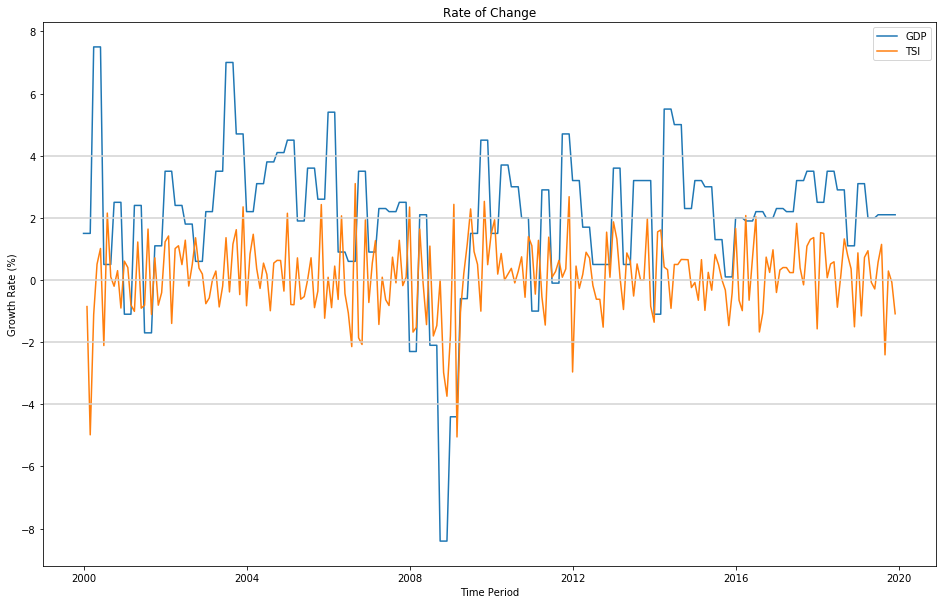

In [20]:
# Plot some of the data.  You can add in different columns from the dataset by uncommenting.
#plt.plot(merged_data['RAIL_FRT_PCT'], label='Rail Frt')
plt.plot(merged_data['OBS_DATE'], merged_data['Real_gdp_qtr_growth']*100.0, label='GDP')
#plt.plot(merged_data['OBS_DATE'], merged_data['RAIL_INTERMOD_PCT'], label='Rail Intermod')
#plt.plot(merged_data['OBS_DATE'], merged_data['WATERBORNE_PCT'], label='Water')
#plt.plot(merged_data['OBS_DATE'], merged_data['TRUCK_PCT'], label='Truck')
#plt.plot(merged_data['OBS_DATE'], merged_data['AIR_RTMFM_PCT'], label='Air and Mail Frt')
plt.plot(merged_data['OBS_DATE'], merged_data['TSI_PCT']*100.0, label='TSI')
plt.title('Rate of Change')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Time Period')
plt.legend()
plt.axhline(-4, 0, 250, c='lightgrey')
plt.axhline(-2, 0, 250, c='lightgrey')
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)

In [21]:
x = merged_data.loc[:, ('RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT')]
x = x.drop([0]) #drop first row as it will have NA for pct_change values

y = merged_data.loc[:, ('gdp_is_increasing')]
y = y.drop(index=0) #drop first row so that it matches the input

# Run Recursive Feature Elmination on all rows of data
from sklearn.feature_selection import RFE
rfelogreg = LogisticRegression()  # Run it for LogisticRegression estimator
selector = RFE(rfelogreg, 1)      # By passing a 1 for n_features_to_select, it will return a rank order for all
selector = selector.fit(x, y)       
print(selector.support_)   # Returns a booling indicating if the column should be included
print(selector.ranking_)   # Ranking will indicate the rank of each input column

[False False False False  True False]
[6 2 5 4 1 3]


In [22]:
# This will provide the marginal effects of the input columns.
# P values of less than 0.05 are significant variables.

import statsmodels.api as sm
logit_model = sm.Logit(y, x)
resultlogit = logit_model.fit()
print(resultlogit.summary2())

Optimization terminated successfully.
         Current function value: 0.653114
         Iterations 5
                          Results: Logit
Model:               Logit              Pseudo R-squared:  -0.729  
Dependent Variable:  gdp_is_increasing  AIC:               324.1883
Date:                2020-06-14 16:58   BIC:               345.0471
No. Observations:    239                Log-Likelihood:    -156.09 
Df Model:            5                  LL-Null:           -90.291 
Df Residuals:        233                LLR p-value:       1.0000  
Converged:           1.0000             Scale:             1.0000  
No. Iterations:      5.0000                                        
-------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-------------------------------------------------------------------
RAIL_FRT_PCT      -15.0434   8.6828 -1.7325 0.0832 -32.0614  1.9746
RAIL_INTERMOD_PCT  19.8824   8.0396  2.47

In [23]:
x

,RAIL_FRT_PCT,RAIL_INTERMOD_PCT,WATERBORNE_PCT,TRUCK_PCT,AIR_RTMFM_PCT,TSI_PCT
1,0.002418,0.004187,-0.122744,-0.006227,0.022255,-0.008547
2,-0.010116,-0.005339,0.080247,-0.071429,-0.012715,-0.049808
3,-0.007898,0.000374,-0.032381,-0.017544,0.027129,-0.011089
4,0.003469,-0.000394,0.033465,0.002747,-0.011540,0.005097
5,-0.007449,-0.010582,-0.076190,0.026027,-0.003281,0.010142
...,...,...,...,...,...,...
235,-0.006389,-0.005781,0.034623,0.011804,0.010462,0.011461
236,-0.026488,-0.000894,-0.015748,-0.025000,-0.038702,-0.024079
237,-0.018971,-0.022953,0.022000,0.005983,0.013972,0.002903
238,0.007188,-0.005856,-0.001957,-0.005947,-0.001251,-0.000724


In [24]:
x.describe()

,RAIL_FRT_PCT,RAIL_INTERMOD_PCT,WATERBORNE_PCT,TRUCK_PCT,AIR_RTMFM_PCT,TSI_PCT
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,-0.001098,0.001757,0.001000,0.001662,0.002104,0.001163
std,0.020348,0.022126,0.050563,0.015129,0.034186,0.012144
min,-0.075566,-0.089458,-0.148492,-0.071429,-0.116712,-0.050495
25%,-0.011048,-0.008095,-0.026592,-0.007045,-0.014948,-0.006422
50%,-0.001436,0.002137,0.002119,0.002364,0.001204,0.002107
75%,0.010103,0.012127,0.024176,0.010088,0.018454,0.008440
max,0.086496,0.167974,0.158960,0.040047,0.276234,0.031022


## Create the training data set

In [32]:

test_data_split = 230  #this will be the number of weeks in the test data set, 
# the remainder of the data will be in the train data set.

#Calculate the split date to use
max_obs_date = merged_data['OBS_DATE'].max()
print('Max Observed Date: {0}'.format(max_obs_date))
split_date = max_obs_date - timedelta(weeks=test_data_split) 
print('Split Date: {0}'.format(split_date))

Max Observed Date: 2019-12-01 00:00:00
Split Date: 2015-07-05 00:00:00


In [33]:
# Create x_train and y_train dataframes
x_train = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'RAIL_FRT_PCT':'TSI_PCT']
x_train = x_train.drop([0]) #drop first row as it will have NA for pct_change values
y_train_class = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'gdp_is_increasing'] #ydata for classifier models
y_train_class = y_train_class.drop([0]) #drop first row as it will have NA for pct_change values
y_train_rate = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'Real_gdp_qtr_growth'] #y data for regression models
y_train_rate = y_train_rate.drop([0]) #drop first row as it will have NA for pct_change values

print('x_train row count: {0}'.format(len(x_train.index)))
print('y_train_class row count: {0}'.format(len(y_train_class.index)))
print('y_train_rate row count: {0}'.format(len(y_train_rate.index)))

x_test = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'RAIL_FRT_PCT':'TSI_PCT']
y_test_class = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'gdp_is_increasing']
y_test_rate = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'Real_gdp_qtr_growth']

print('x_test row count: {0}'.format(len(x_test.index)))
print('y_test_class row count: {0}'.format(len(y_test_class.index)))
print('y_test_rate row count: {0}'.format(len(y_test_rate.index)))

x_train row count: 186
y_train_class row count: 186
y_train_rate row count: 186
x_test row count: 53
y_test_class row count: 53
y_test_rate row count: 53


In [36]:
# Normalize the training and test dats sets.
# Calculate the mean and standard deviation of the training data set.
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

#Normalize the training data set to have a mean of 0 and standard deviation of 1.
x_train_std = x_train - mean
x_train_std = x_train / std

#Normalize the test data set to have a mean of 0 and standard deviation of 1.
x_test_std = x_test - mean
x_test_std = x_test / std

In [37]:
x_train_std

,RAIL_FRT_PCT,RAIL_INTERMOD_PCT,WATERBORNE_PCT,TRUCK_PCT,AIR_RTMFM_PCT,TSI_PCT
1,0.120697,0.176116,-2.332309,-0.394008,0.593212,-0.675076
2,-0.504862,-0.224567,1.524809,-4.519838,-0.338917,-3.934062
3,-0.394149,0.015749,-0.615285,-1.110136,0.723125,-0.875829
4,0.173143,-0.016569,0.635876,0.173840,-0.307595,0.402568
5,-0.371762,-0.445110,-1.447730,1.646955,-0.087458,0.801053
...,...,...,...,...,...,...
182,1.398839,7.065461,-2.284986,1.670275,-1.979403,0.517503
183,0.004739,-0.322018,2.096084,-1.564731,0.534390,-0.771201
184,-1.888744,-0.650667,0.984957,0.577586,-0.535998,0.194701
185,-0.764527,-0.033599,-0.507226,-0.063596,-0.354520,-0.258963


In [ ]:
#x_train_std

In [38]:
y_train_class.head()

1    1
2    1
3    1
4    1
5    1
Name: gdp_is_increasing, dtype: int64

In [39]:
# Recursive Feature Elimination (RFE) for training set
from sklearn.feature_selection import RFE
rfelogreg = LogisticRegression()
selector = RFE(rfelogreg, 1)
selector = selector.fit(x_train, y_train_class)
print(selector.support_)
print(selector.ranking_)

[False False False False  True False]
[6 2 5 4 1 3]


In [40]:
# Marginal effects for training set

import statsmodels.api as sm
logit_model=sm.Logit(y_train_class, x_train)
resultlogit=logit_model.fit()
print(resultlogit.summary2())

Optimization terminated successfully.
         Current function value: 0.646620
         Iterations 6
                           Results: Logit
Model:                 Logit              Pseudo R-squared:  -0.464  
Dependent Variable:    gdp_is_increasing  AIC:               252.5425
Date:                  2020-06-14 17:40   BIC:               271.8970
No. Observations:      186                Log-Likelihood:    -120.27 
Df Model:              5                  LL-Null:           -82.175 
Df Residuals:          180                LLR p-value:       1.0000  
Converged:             1.0000             Scale:             1.0000  
No. Iterations:        6.0000                                        
---------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
---------------------------------------------------------------------
RAIL_FRT_PCT      -15.3412  10.9285 -1.4038 0.1604  -36.7607   6.0782
RAIL_INTERMOD_PC

In [41]:
# RFE for normalized training set
from sklearn.feature_selection import RFE
rfelogreg = LogisticRegression()
selector = RFE(rfelogreg, 1)
selector = selector.fit(x_train_std, y_train_class)
print(selector.support_)
print(selector.ranking_)

[False False False False  True False]
[3 2 5 6 1 4]


In [42]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train_class, x_train_std)
resultlogit=logit_model.fit()
print(resultlogit.summary2())

Optimization terminated successfully.
         Current function value: 0.646620
         Iterations 5
                         Results: Logit
Model:              Logit             Pseudo R-squared: -0.464  
Dependent Variable: gdp_is_increasing AIC:              252.5425
Date:               2020-06-14 17:44  BIC:              271.8970
No. Observations:   186               Log-Likelihood:   -120.27 
Df Model:           5                 LL-Null:          -82.175 
Df Residuals:       180               LLR p-value:      1.0000  
Converged:          1.0000            Scale:            1.0000  
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
RAIL_FRT_PCT      -0.3074   0.2190 -1.4038 0.1604 -0.7366 0.1218
RAIL_INTERMOD_PCT  0.5963   0.2223  2.6829 0.0073  0.1607 1.0320
WATERBORNE_PC

In [ ]:
#col1 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']
#x_train[col1]
#x_train[['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']]

In [52]:
# Create a Logistic Regression model that to use in a grid search.
def train_logregression_model(columnset, x_train, x_train_std, y_train_class, stdinputs, classweights, regfactor):
    #stdinputs=True, classweights={1:1, 0:1}, regfactor=1.0):
    #Setup a logistics regression model using the parameters that were passed in.
    
    clf = LogisticRegression(solver='liblinear', C=regfactor, class_weight=classweights)
    if stdinputs:
        xinput = x_train_std[columnset]
    else:
        xinput = x_train[columnset]
    
    logreg = clf.fit(xinput, y_train_class)
    y_hat_train_class = logreg.predict(xinput)
    return y_hat_train_class

In [103]:
# Run a grid search that will use different columns of the input data set, standardized vs non-standardized inputs,
# different class weights, and different regularization factors.

columnsetall = ['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
columnset1 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']
columnset2 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
columnset3 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT', 'TRUCK_PCT']
columnset4 = ['TSI_PCT']

results = pd.DataFrame(columns=['TestCase', 'StdInput', 'ColumnSet', 'ClassWeight', 'RegFactor', 'Accuracy', 
                                'Class 0 Recall', 'Combined Score'])

for stdinput in [True, False]:
    for columnset in [columnsetall, columnset1, columnset2, columnset3, columnset4]:
        for classweight in [{1:1, 0:4}, {1:1, 0:5}, {1:1, 0:6}, {1:1, 0:5.2}]:
            for regfactor in [0.60, 0.80, 1.0]:
                testcase = 'StdInput={0}, ColumnSet={1}, ClassWeight={2}, RegFactor={3:0.2f}'.format(stdinput, columnset, classweight, regfactor)
                print(testcase)
                y_hat_train_class = train_logregression_model(columnset, x_train, x_train_std, y_train_class, stdinput, classweight, regfactor)
                classreport = classification_report(y_train_class, y_hat_train_class, zero_division=0, output_dict=True)
                accuracy = classreport['accuracy']
                class0recall = classreport['0']['recall']
                combinedscore = accuracy + class0recall
                print('Accuracy: {0:0.2f}'.format(accuracy))
                print('Class 0 Recall: {0:0.2f}'.format(class0recall))
                results = results.append(pd.Series([testcase, stdinput, columnset, classweight, regfactor, accuracy, 
                                                    class0recall, combinedscore], index=results.columns ), ignore_index=True)
                

StdInput=True, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 4}, RegFactor=0.60
Accuracy: 0.75
Class 0 Recall: 0.40
StdInput=True, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 4}, RegFactor=0.80
Accuracy: 0.74
Class 0 Recall: 0.40
StdInput=True, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 4}, RegFactor=1.00
Accuracy: 0.73
Class 0 Recall: 0.40
StdInput=True, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 5}, RegFactor=0.60
Accuracy: 0.70
Class 0 Recall: 0.57
StdInput=True, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 5}, RegFactor=0.80
Accuracy: 0.69
Class 0 Recall: 0.57


StdInput=False, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 5}, RegFactor=0.60
Accuracy: 0.85
Class 0 Recall: 0.17
StdInput=False, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 5}, RegFactor=0.80
Accuracy: 0.83
Class 0 Recall: 0.17
StdInput=False, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 5}, RegFactor=1.00
Accuracy: 0.81
Class 0 Recall: 0.23
StdInput=False, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 6}, RegFactor=0.60
Accuracy: 0.17
Class 0 Recall: 1.00
StdInput=False, ColumnSet=['RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'WATERBORNE_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT'], ClassWeight={1: 1, 0: 6}, RegFactor=0.80
Accuracy: 0.17
Class 0 Recall: 

In [115]:
# Take a look at the results of the grid search. Results were stored in a pandas dataframe.
results.sort_values('Class 0 Recall', inplace=True, ascending=False)
#subresults = results[['Combined Score', 'Accuracy', 'TestCase', 'Class 0 Recall']][results['Accuracy'] > 0.8] #.to_numpy()
results[['Combined Score', 'Accuracy', 'Class 0 Recall', 'StdInput','RegFactor', 'ClassWeight','ColumnSet']][results['Class 0 Recall'] > .5]

,Combined Score,Accuracy,Class 0 Recall,StdInput,RegFactor,ClassWeight,ColumnSet
114,1.161290,0.161290,1.000000,False,0.6,"{1: 1, 0: 6}",[TSI_PCT]
66,1.166667,0.166667,1.000000,False,0.6,"{1: 1, 0: 6}","[RAIL_FRT_PCT, RAIL_INTERMOD_PCT, WATERBORNE_P..."
116,1.161290,0.161290,1.000000,False,1.0,"{1: 1, 0: 6}",[TSI_PCT]
115,1.161290,0.161290,1.000000,False,0.8,"{1: 1, 0: 6}",[TSI_PCT]
102,1.166667,0.166667,1.000000,False,0.6,"{1: 1, 0: 6}","[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT, TR..."
78,1.166667,0.166667,1.000000,False,0.6,"{1: 1, 0: 6}","[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT]"
91,1.166667,0.166667,1.000000,False,0.8,"{1: 1, 0: 6}","[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT]"
103,1.166667,0.166667,1.000000,False,0.8,"{1: 1, 0: 6}","[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT, TR..."
67,1.166667,0.166667,1.000000,False,0.8,"{1: 1, 0: 6}","[RAIL_FRT_PCT, RAIL_INTERMOD_PCT, WATERBORNE_P..."
104,1.166667,0.166667,1.000000,False,1.0,"{1: 1, 0: 6}","[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT, TR..."


Training data score: 0.23
Training average precision score: 0.84
Training precision score: 0.84
Training recall score: 0.10
Training f1 score: 0.18


Text(0.5, 1.0, '2-class Precision-Recall curve: Ave Precision=0.84')

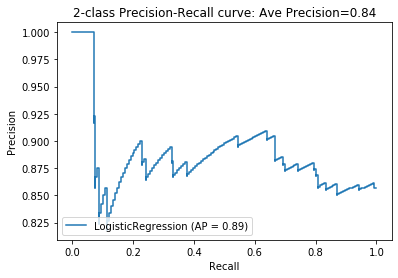

In [74]:
x_train_selected_features = x_train[['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']] #, 'TSI_PCT']]  #, 'TSI_PCT'
x_test_selected_features = x_test[['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']]#, 'TSI_PCT']] #set this here for consistency

#load the model
clf = LogisticRegression(solver='liblinear', C=1.0, class_weight={1:1, 0:5.5}) #, multi_class='ovr')    liblinear
#clf = LogisticRegression(solver='liblinear', C=1.0) #, class_weight='balanced') #, multi_class='ovr')    liblinear
#fit the model
logreg = clf.fit(x_train_selected_features, y_train_class)
print('Training data score: {0:0.2f}'.format(logreg.score(x_train_selected_features, y_train_class)))
#print(logreg.score(x_train_selected_features, y_train_class))

y_hat_train_class = logreg.predict(x_train_selected_features)

avg_precision = average_precision_score(y_train_class, y_hat_train_class)
print('Training average precision score: {0:0.2f}'.format(avg_precision))

precision = precision_score(y_train_class, y_hat_train_class, zero_division=0)
print('Training precision score: {0:0.2f}'.format(precision))

recall = recall_score(y_train_class, y_hat_train_class)
print('Training recall score: {0:0.2f}'.format(recall))

f1_score_val = f1_score(y_train_class, y_hat_train_class)
print('Training f1 score: {0:0.2f}'.format(f1_score_val))


disp = plot_precision_recall_curve(logreg, x_train_selected_features, y_train_class)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Ave Precision={0:0.2f}'.format(avg_precision))


In [143]:
# Generate a classification report to see details for each class.

from sklearn.metrics import classification_report
#print(classification_report(y_train_class, y_hat_train_class, zero_division=0))
classreport = classification_report(y_train_class, y_hat_train_class, zero_division=0)   #, output_dict=True)
print(classreport) #['0']['recall']

              precision    recall  f1-score   support

           0       0.18      0.47      0.26        30
           1       0.85      0.59      0.70       156

    accuracy                           0.57       186
   macro avg       0.52      0.53      0.48       186
weighted avg       0.74      0.57      0.63       186



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_logreg = confusion_matrix(y_train_class, y_hat_train_class)
print(confusion_matrix_logreg)

In [ ]:
y_hat_train_class

In [ ]:
y_train_class #.to_numpy()

In [ ]:
#evaluate the model by using a test set
y_hat_test_class = clf.predict(x_test_selected_features)
print('Classifier test data score: {0:0.2f}'.format(clf.score(x_test_selected_features, y_test_class)))
#print the accuracy
#print('Classifier test accuracy: {0}'.format(np.average(y_hat_test_class == y_test_class)))

avg_precision = average_precision_score(y_test_class, y_hat_test_class)
print('Test average precision score: {0:0.2f}'.format(avg_precision))

precision = precision_score(y_test_class, y_hat_test_class)
print('Test precision score: {0:0.2f}'.format(precision))

recall = recall_score(y_test_class, y_hat_test_class)
print('Test recall score: {0:0.2f}'.format(recall))

f1_score_val = f1_score(y_test_class, y_hat_test_class)
print('Test f1 score: {0:0.2f}'.format(f1_score_val))


disp = plot_precision_recall_curve(clf, x_test_selected_features, y_test_class)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(avg_precision))



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_hat_test_class, zero_division=0))

In [ ]:
y_hat_test_class

In [ ]:
y_test_class.to_numpy()

In [102]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train_class),
                                                 y_train_class)
class_weights

array([3.1       , 0.59615385])

In [116]:
from keras import regularizers
from keras import models
from keras import layers

Using TensorFlow backend.


In [147]:
#Create a neural network classifier model.

def get_nn_model_regularization(penalty, reg_type="L2", dense_layers=16):
    model_regn = models.Sequential()
    
    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l1(penalty)))
        
    model_regn.add(layers.BatchNormalization())

    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', kernel_regularizer=regularizers.l1(penalty)))

    model_regn.add(layers.BatchNormalization())
    model_regn.add(layers.Dense(1, activation='sigmoid'))
    
    #model_regn.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    model_regn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_regn 

In [ ]:
class_weights = [12, 1]

In [ ]:
x_train_std

In [168]:
# Run the model on a subset of the input data columns.
x_train_std_input = x_train[['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']].to_numpy()  #, 'TSI_PCT']]
x_test_std_input = x_test[['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']].to_numpy()

model_reg = get_nn_model_regularization(penalty=0.01) # 0.006
model_reg.optimizer.lr = 0.001 #0.005
#history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2)
history_reg = model_reg.fit(x=x_train_std_input, class_weight=class_weights,    # x_train_std_input
                            y=y_train_class.to_numpy(), epochs=150, validation_split=0.2)

Train on 148 samples, validate on 38 samples
Epoch 1/150
148/148 [==============================] - 3s 22ms/step - loss: 0.9419 - acc: 0.5338 - val_loss: 0.8662 - val_acc: 0.5263
Epoch 2/150
148/148 [==============================] - 0s 108us/step - loss: 0.8866 - acc: 0.6081 - val_loss: 0.9573 - val_acc: 0.4474
Epoch 3/150
148/148 [==============================] - 0s 115us/step - loss: 0.8667 - acc: 0.5811 - val_loss: 0.9361 - val_acc: 0.4474
Epoch 4/150
148/148 [==============================] - 0s 88us/step - loss: 0.8548 - acc: 0.5946 - val_loss: 0.9115 - val_acc: 0.4474
Epoch 5/150
148/148 [==============================] - 0s 115us/step - loss: 0.8255 - acc: 0.6486 - val_loss: 0.8652 - val_acc: 0.4737
Epoch 6/150
148/148 [==============================] - 0s 115us/step - loss: 0.8085 - acc: 0.6824 - val_loss: 0.8519 - val_acc: 0.5000
Epoch 7/150
148/148 [==============================] - 0s 115us/step - loss: 0.8083 - acc: 0.6824 - val_loss: 0.8837 - val_acc: 0.4737
Epoch 8/150


Epoch 61/150
148/148 [==============================] - 0s 108us/step - loss: 0.5020 - acc: 0.8378 - val_loss: 0.6431 - val_acc: 0.8158
Epoch 62/150
148/148 [==============================] - 0s 115us/step - loss: 0.5118 - acc: 0.8446 - val_loss: 0.6308 - val_acc: 0.7895
Epoch 63/150
148/148 [==============================] - 0s 115us/step - loss: 0.5028 - acc: 0.8378 - val_loss: 0.6325 - val_acc: 0.7895
Epoch 64/150
148/148 [==============================] - 0s 115us/step - loss: 0.5020 - acc: 0.8514 - val_loss: 0.6074 - val_acc: 0.8158
Epoch 65/150
148/148 [==============================] - 0s 108us/step - loss: 0.5171 - acc: 0.8243 - val_loss: 0.6028 - val_acc: 0.7895
Epoch 66/150
148/148 [==============================] - 0s 101us/step - loss: 0.5001 - acc: 0.8446 - val_loss: 0.6558 - val_acc: 0.7895
Epoch 67/150
148/148 [==============================] - 0s 95us/step - loss: 0.4960 - acc: 0.8446 - val_loss: 0.6306 - val_acc: 0.8421
Epoch 68/150
148/148 [===========================

148/148 [==============================] - 0s 108us/step - loss: 0.4371 - acc: 0.8581 - val_loss: 0.4831 - val_acc: 0.8684
Epoch 122/150
148/148 [==============================] - 0s 108us/step - loss: 0.4431 - acc: 0.8581 - val_loss: 0.4561 - val_acc: 0.8421
Epoch 123/150
148/148 [==============================] - 0s 115us/step - loss: 0.4506 - acc: 0.8446 - val_loss: 0.4272 - val_acc: 0.8684
Epoch 124/150
148/148 [==============================] - 0s 115us/step - loss: 0.4706 - acc: 0.8446 - val_loss: 0.4317 - val_acc: 0.8684
Epoch 125/150
148/148 [==============================] - 0s 108us/step - loss: 0.4559 - acc: 0.8514 - val_loss: 0.4742 - val_acc: 0.8684
Epoch 126/150
148/148 [==============================] - 0s 101us/step - loss: 0.4619 - acc: 0.8514 - val_loss: 0.4518 - val_acc: 0.8947
Epoch 127/150
148/148 [==============================] - 0s 108us/step - loss: 0.4536 - acc: 0.8514 - val_loss: 0.4155 - val_acc: 0.8684
Epoch 128/150
148/148 [==============================] 

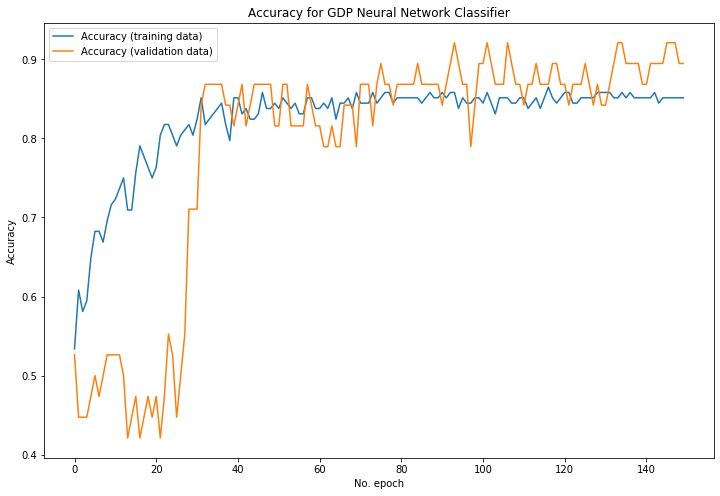

In [169]:
# Plot the accuracy for the training data and validation data over the epochs.
plt.plot(history_reg.history['acc'], label='Accuracy (training data)')
plt.plot(history_reg.history['val_acc'], label='Accuracy (validation data)')
plt.title('Accuracy for GDP Neural Network Classifier')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [125]:
history_reg

In [ ]:
# the predict_classes will round the values to either 0 or 1 for the binary output
predictions_train_reg = model_reg.predict_classes(x_train)  #x_train_std_input

In [ ]:
predictions_train_reg.tolist()

In [ ]:
#predictions_train_reg
confusion_matrix_nn = confusion_matrix(y_train_class, predictions_train_reg.tolist())
print(confusion_matrix_nn)

In [170]:
predictions_test_reg = model_reg.predict_classes(x_test_std_input)   # x_test_std_input

In [171]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, predictions_test_reg, zero_division=0))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        53

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



In [172]:
predictions_test_reg
confusion_matrix_nntest = confusion_matrix(y_test_class, predictions_test_reg)
print(confusion_matrix_nntest)

[[53]]


In [ ]:
predictions_test_reg

In [ ]:

lin = LinearRegression() 

reg = lin.fit(x_train_normalized, y_train_rate)
r2coeffofdet = lin.score(x_train_normalized, y_train_rate)

print('R2 score:', r2coeffofdet)   # This is the coefficient of determination.

y_hat_train_rate = reg.predict(x_train_normalized)

RMSE = np.sqrt(mean_squared_error(y_train_rate, y_hat_train_rate))
print('RMSE:', RMSE)

print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures 

poly = PolynomialFeatures(degree = 2) 
x_train_normalized_poly = poly.fit_transform(x_train_normalized)

poly.fit(x_train_normalized_poly, y_train_rate)

lin_poly = LinearRegression()

reg_poly = lin_poly.fit(x_train_normalized_poly, y_train_rate)

r2coeffofdet = lin_poly.score(x_train_normalized_poly, y_train_rate)
print('R2 score:', r2coeffofdet)   # This is the coefficient of determination.

y_hat_train_rate_poly = reg_poly.predict(x_train_normalized_poly)

RMSE = np.sqrt(mean_squared_error(y_train_rate, y_hat_train_rate_poly))
print('RMSE:', RMSE)

print('Coefficients:', reg_poly.coef_)
print('Intercept:', reg_poly.intercept_)

In [ ]:
y_hat_train_rate_poly

In [ ]:
y_train_rate